# Basic characterizations of UA Q2
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qm.octave import QmOctaveConfig
from quam import QuAM
from scipy.io import savemat, loadmat

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
#from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber
import xarray as xr

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q2
TLS_index = 0 # for TLS of interest
dc_flux_index = 1 # for dc line

2024-05-19 21:09:47,778 - qm - INFO     - Starting session: b95dcf2d-3643-41fe-a91e-1a01f943cbea


In [2]:
Analysis = AnalysisHandle("quam_state_q1.json")
machine = Analysis.get_machine()
Experiment = ExperimentHandle(machine)

In [ ]:
# initialize Labber-controlled hardware
# get values from QDAC first
#machine = Experiment.set_Labber.get_value_from_QDAC(machine)
# set all Labber settings
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
# set octave to external clock
Experiment.set_octave.set_clock(machine)

In [ ]:
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [ ]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

## Time of Flight

In [ ]:
# time_of_flight
# experiment
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.time_of_flight(machine,qubit_index, n_avg = 10E3, cd_time = 10E3, to_simulate = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(expt_dataset)

In [ ]:
# update the offset
machine.global_parameters.downconversion_offset_I[0] += dc_offset_i
machine.global_parameters.downconversion_offset_Q[0] += dc_offset_q
machine.resonators[qubit_index].downconversion_offset_I = machine.global_parameters.downconversion_offset_I[0]
machine.resonators[qubit_index].downconversion_offset_Q = machine.global_parameters.downconversion_offset_Q[0]
#machine.global_parameters.time_of_flight = 304-0
machine = Analysis.set_machine(machine)

## Resonator spectroscopy

### 1D resonator spectroscopy

In [ ]:
%matplotlib qt
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-5E6,5E6 + 1.0,0.05E6)
machine, expt_dataset = Experiment.exp1D.RR.rr_freq(machine, res_freq_sweep, qubit_index, n_avg = 1E3, cd_time = 10E3, live_plot = False,
                                                    readout_state = 'g', to_simulate = False, data_process_method = 'Amplitude')
# Readout in excited state
# machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
#                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

In [ ]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(expt_dataset)
machine.resonators[qubit_index].f_readout = res_freq + 0E6

In [ ]:
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

### 2D resonator spectroscopy

In [ ]:
res_freq_sweep = np.arange(7.127E9,7.138E9 + 1.0,0.05E6)
dc_flux_sweep = np.arange(-9,9.001,0.1)
%matplotlib qt
machine, expt_dataset = Experiment.exp2D.RR.rr_vs_dc_flux(machine, res_freq_sweep, dc_flux_sweep, qubit_index,
                                                          n_avg = 1000, cd_time = 10E3, live_plot = True)

In [ ]:
expt_dataset

In [ ]:
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0517\2024-05-17_q1_res_spec2D_2.nc")

In [ ]:
expt_dataset = expt_dataset.set_coords("DC Flux")
expt_dataset = expt_dataset.set_coords("Readout Frequency")

In [ ]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(expt_dataset, to_plot = True)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param = ham_param, to_plot = True)

In [ ]:
# save the fitting parameters
machine.resonators[qubit_index].tuning_curve = ham_param
machine.qubits[qubit_index].DC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

In [ ]:
# save the sweep spot flux according to fitted parameter
machine.dc_flux[dc_flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param)
machine = Analysis.set_machine(machine)

if 2D res spectroscopy is just to test the experiment, and I want to go back to sweet spot

In [ ]:
machine = Analysis.update_machine_res_frequency_sweet_spot(machine, qubit_index, dc_flux_index) 
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50e6
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

## 1D qubit spectroscopy @ sweep spot

In [ ]:
if True: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.dc_flux[dc_flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz

qubit_freq_sweep = int(qubit_freq_est) + np.arange(-70E6, 70E6 + 1, 1E6)
    
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.Rabi.qubit_freq(machine, qubit_freq_sweep, qubit_index, pi_amp_rel = 1.0, live_plot = False,
                                                         ff_amp = 0.0, n_avg = 1E3, cd_time = 30E3, to_simulate = False, data_process_method = 'I')

In [ ]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'I')
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6

In [ ]:
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

## Rabi

### Time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 240 + 0.1, 1)  # in ns
machine, expt_dataset = Experiment.exp1D.Rabi.rabi_length(machine, rabi_duration_sweep, qubit_index, pi_amp_rel = 1.0, live_plot = True, 
                                                          n_avg = 2E3, cd_time = 25E3, to_simulate = False, data_process_method = 'I')

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", to_plot = True, data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].pi_length = 100
# machine.qubits[qubit_index].pi_amp[0] = 0.0270983
machine = Analysis.set_machine(machine)

### Power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.1, 2.0, 0.025) 
machine, expt_dataset = Experiment.exp1D.Rabi.rabi_amp(machine, rabi_amp_sweep_rel, qubit_index, ff_amp = 0.0, live_plot = True,
                                                       n_avg = 10E3, cd_time = 20E3, data_process_method = 'I')

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", data_process_method = 'I')
machine.qubits[qubit_index].pi_amp = pi_pulse_amp
machine = Analysis.set_machine(machine)

## Single-Shot Readout

### Find frequency between g, e

In [ ]:
%matplotlib qt
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-5E6,5E6 + 1.0,0.05E6)
machine, expt_dataset = Experiment.exp1D.RR.rr_freq_ge(machine, res_freq_sweep, qubit_index, n_avg = 1E3, cd_time = 10E3,
                                                    to_simulate = False, simulation_len = 1000, live_plot = True, data_process_method = 'Phase')

In [ ]:
%matplotlib inline
res_freq_phase = Analysis.exp1D.rr_freq_ge(expt_dataset)

In [ ]:
# doesn't have to update. Use res_freq_phase
machine.resonators[qubit_index].f_readout = res_freq_phase + 0E6
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

### IQ blobs

In [ ]:
%matplotlib inline
machine, expt_dataset = Experiment.exp1D.RR.single_shot_IQ_blob(machine, qubit_index, n_avg = 30E3, cd_time = 25E3, final_plot = False)

In [ ]:
%matplotlib inline
angle, threshold, fidelity, gg, ge, eg, ee = Analysis.exp1D.two_state_discriminator(expt_dataset)

In [ ]:
# set the rotation angle
machine.resonators[qubit_index].rotation_angle -= angle # note this is the change value not the absolute value!
machine.resonators[qubit_index].ge_threshold = threshold
machine = Analysis.set_machine(machine)

### Readout freq optimization

In [ ]:
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-1.5E6, 1.5E6 + 1, 0.05E6)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_freq_optimization(machine, res_freq_sweep, qubit_index, n_avg = 10E3, cd_time = 25E3, 
                                                           final_plot = True, live_plot = True)

In [ ]:
%matplotlib inline
res_freq = Analysis.exp1D.peak_fit(expt_dataset,method="Gaussian", data_process_method = 'SNR')

In [ ]:
machine.resonators[qubit_index].f_readout = res_freq + 0E6
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

### Readout pulse amp and duration (by qubit relaxation during readout)

In [ ]:
%matplotlib qt
res_duration_sweep_abs = np.arange(300, 2000 + 1, 60)
res_amp_sweep_abs = np.arange(0.15,0.45,0.002)
machine, expt_dataset = Experiment.exp2D.RR.rr_pulse_optimize(machine, res_duration_sweep_abs, res_amp_sweep_abs, qubit_index, n_avg=1E3, 
                                                              cd_time=25E3, live_plot = True, data_process_method = 'I')

In [ ]:
machine.resonators[qubit_index].readout_pulse_amp = 0.45
machine.resonators[qubit_index].readout_pulse_length = 600
machine = Analysis.set_machine(machine)

### Readout duration optimization

In [ ]:
division_length = 40
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_duration_optimization(machine, division_length, qubit_index,
                                                                    readout_len = 2000, n_avg = 10E3, cd_time = 25E3)

In [ ]:
machine.resonators[qubit_index].readout_pulse_length = 940
machine = Analysis.set_machine(machine)

### Readout amp optimization

In [ ]:
res_amp_sweep = np.arange(0.5,1.5 + 1E-4, 0.01)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_amp_optimization(machine, res_amp_sweep, qubit_index,
                              n_avg = 5E3, cd_time = 25E3, final_plot= True)

In [ ]:
%matplotlib inline
readout_amp = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'Fidelity')

In [ ]:
machine.resonators[qubit_index].readout_pulse_amp = 0.48
machine = Analysis.set_machine(machine)

## Qubit T1

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(100,30E3+1,1E3)
machine, expt_dataset = Experiment.exp1D.T1.qubit_T1(machine, tau_sweep_abs, qubit_index, n_avg = 4E3, cd_time = 40E3, live_plot = True,
                                                               to_simulate = False, simulation_len = 15_000, data_process_method = 'I')

In [ ]:
%matplotlib inline
qubit_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')
machine.qubits[qubit_index].T1 = qubit_T1 + 0E6
machine = Analysis.set_machine(machine)

## Qubit Ramsey

In [ ]:
%matplotlib qt
ramsey_duration_sweep = np.arange(16, 20000 + 0.1, 60)  # in units of ns
machine, expt_dataset = Experiment.exp1D.Ramsey.ramsey(machine, ramsey_duration_sweep, qubit_index, detuning = 1E6, live_plot = True,
                                                       n_avg = 2E3, cd_time = 25E3, to_simulate = False, data_process_method = 'I')

In [ ]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(expt_dataset, data_process_method = 'I')
machine.qubits[qubit_index].T2 = q_T2star + 0E6
machine = Analysis.set_machine(machine)

## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-190E6, -150E6 + 1, 0.5E6) 
machine, expt_dataset = Experiment.exp1D.Rabi.ef_freq(machine, ef_freq_sweep, qubit_index, pi_amp_rel_ef = 1.0, n_avg = 2E3, live_plot = True,
                                                      cd_time = 30E3, readout_state = 'g', to_simulate = False, data_process_method = 'I')

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - ef_freq
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 240 + 0.1, 4)  # in ns
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, expt_dataset = Experiment.exp1D.Rabi.ef_rabi_length(machine, rabi_duration_sweep, qubit_index, pi_amp_rel_ef = 1.0, live_plot = True,
                                                                             n_avg = 2E3, cd_time = 30E3, readout_state = 'g', 
                                                                             to_simulate = False, simulation_len = 10_000, data_process_method = 'I')

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].pi_length_ef = 180
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 2.0, 0.025) 
machine, expt_dataset = Experiment.exp1D.Rabi.ef_rabi_amp(machine, rabi_amp_sweep_rel, qubit_index, n_avg = 2E3, cd_time = 30E3, live_plot = True,
                                                          readout_state = 'g', to_simulate = False, simulation_len = 1000, data_process_method = 'I')

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].pi_amp_ef = pi_pulse_amp
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs dc flux

In [ ]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.dc_flux[dc_flux_index].max_frequency_point + np.arange(-1.2,1.2+1E-4,0.05)
qubit_if_sweep = np.arange(-100E6, 100E6, 1E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(machine, dc_flux_sweep, qubit_if_sweep, qubit_index,
                                 n_avg = 500, cd_time = 25E3, final_plot = True, live_plot = False)

In [ ]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 2, to_plot = False)
machine.dc_flux[dc_flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param) + 0E1
print(f"sweet spot flux: {machine.dc_flux[dc_flux_index].max_frequency_point:.5f} V")

In [ ]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True)
machine.qubits[qubit_index].DC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

In [ ]:
# go to the sweet spot, if needed
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs fast flux

In [ ]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [ ]:
# try the experiment
%matplotlib qt
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.25+1E-4,0.05)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)
if False: # first time running this, no AC_tuning_curve
    machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(machine, ff_sweep,qubit_if_sweep,
          qubit_index, ff_to_dc_ratio = 5.5, n_avg = 1E3, cd_time = 25E3)
else: # after the first run 
    machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(machine, ff_sweep,qubit_if_sweep,
          qubit_index, ff_to_dc_ratio = None, n_avg = 1E3, cd_time = 25E3)

In [ ]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'I')
machine.qubits[qubit_index].AC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

### fast version, runs blockwise 2D sweeps

In [ ]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4E9, -5E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(machine, qubit_freq_sweep,qubit_if_sweep,
          qubit_index, n_avg = 4E3, cd_time = 20E3, final_plot = True, live_plot = True)

In [ ]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'I')
machine.qubits[qubit_index].AC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

# TLS experiments

## TLS SWAP spectroscopy

In [ ]:
# Go back to the sweet spot and calibrate
machine.qubits[qubit_index].f_01 = int(np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)) + 0E6
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [ ]:
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag=True)

### coarse, no baking

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(16,100 + 0.1,4)
ff_sweep_abs = np.arange(0.1,0.45,0.002)
machine, expt_dataset = Experiment.exp2D.SWAP.swap_coarse(machine, tau_sweep_abs, ff_sweep_abs, qubit_index, 
                      n_avg = 1E3, cd_time = 25E3, live_plot=True)

### fine, with baking

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(4,120,1)
ff_sweep_abs = np.arange(0.1,0.45+1E-4,0.0005)
machine, expt_dataset = Experiment.exp2D.SWAP.swap_fine(machine, tau_sweep_abs, ff_sweep_abs, qubit_index,
                      n_avg = 4E3, cd_time = 25E3, live_plot=True)

#### test of fft

In [3]:
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0518\2024-05-18_q1_swap2D_7.nc")

In [4]:
expt_dataset

<xarray.Dataset>
Dimensions:           (x: 701, y: 116)
Coordinates:
    Fast_Flux         (x) float64 0.1 0.1005 0.101 0.1015 ... 0.449 0.4495 0.45
    Interaction_Time  (y) int32 4 5 6 7 8 9 10 ... 113 114 115 116 117 118 119
Dimensions without coordinates: x, y
Data variables:
    I                 (x, y) float64 0.003392 0.003163 ... -0.0007149 -0.0007477
    Q                 (x, y) float64 -0.007613 -0.007725 ... -0.008107 -0.008105
    Phase             (x, y) float64 -1.152 -1.182 -1.192 ... -1.659 -1.663
    Amplitude         (x, y) float64 0.008334 0.008347 ... 0.008139 0.00814
Attributes:
    created:      2024-05-18 21:55:30
    finished:     2024-05-19 02:33:19
    name:         swap2D
    long_name:    SWAP Spectroscopy
    qubit:        q1
    TLS:          []
    sequence:     with for_(n, 0, n < n_avg, n + 1):\n\twith for_(*from_array...
    units:        V
    description:  q1_swap2D
    directory:    Z:\QM_Data_DF5\2024\05\Data_0518\2024-05-18_q1_swap2D_7

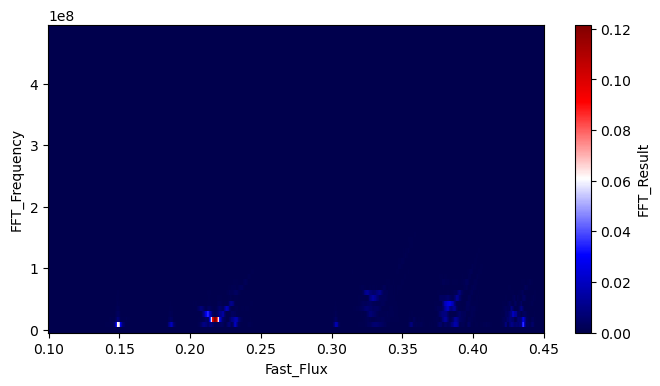

In [7]:
fft_dataset = Analysis.exp2D.SWAP_fft(expt_dataset, to_plot = True)

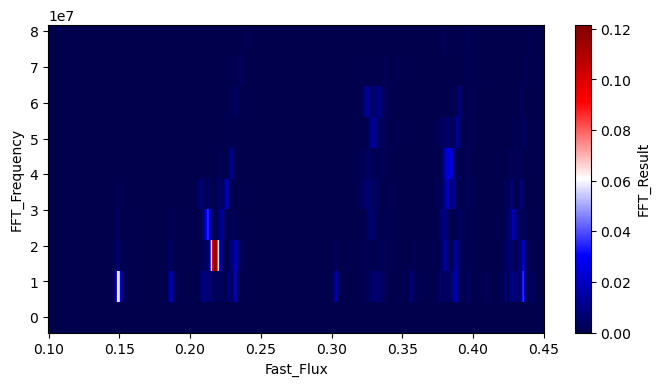

In [14]:
fft_dataset["FFT_Result"].sel(y=slice(0,10)).plot(x = 'Fast_Flux', y = "FFT_Frequency", cmap = "seismic")

In [10]:
fft_dataset

<xarray.Dataset>
Dimensions:        (x: 701, y: 58)
Coordinates:
    FFT_Frequency  (y) float64 0.0 8.621e+06 1.724e+07 ... 4.828e+08 4.914e+08
    Fast_Flux      (x) float64 0.1 0.1005 0.101 0.1015 ... 0.449 0.4495 0.45
Dimensions without coordinates: x, y
Data variables:
    FFT_Result     (x, y) float64 5.245e-33 1.024e-05 ... 2.818e-06 8.436e-06
Attributes:
    name:       fft_swap2D
    long_name:  FFT of SWAP Spectroscopy
    qubit:      q1
    TLS:        []

#### end of test of fft

In [ ]:
machine.flux_lines[flux_index].iswap.length.append(20)
machine.flux_lines[flux_index].iswap.level.append(0.3278)
machine = Analysis.set_machine(machine)

### estiguess of the TLS freq., based on SWAP flux

In [ ]:
machine = Analysis.get_machine()

In [ ]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
machine.qubits[qubit_index].f_tls.append(np.floor(freq_tls[-1]*1E6))    
machine = Analysis.set_machine(machine)

## TLS T1

In [ ]:
TLS_index = 1

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(100,5000E3+1,1E5)
#tau_sweep_abs = np.logspace(100,2000E3,50,endpoint=True)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time_qubit = 30E3, cd_time_TLS = 10000E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

In [ ]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

## TLS drive

### TLS spectroscopy

In [ ]:
TLS_index = 0

In [ ]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level[TLS_index])
TLS_freq_est = np.round(TLS_freq_est * 1E6)
machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist())) + 0E6
machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

In [ ]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] + 0E6
machine = Analysis.set_machine(machine)

In [ ]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

In [ ]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-70E6,70E6+1,1.0E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 1E3, cd_time_qubit = 20E3, cd_time_TLS = 200E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

In [ ]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
machine = Analysis.set_machine(machine)

### TLS rabi

In [ ]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1]

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 300 + 0.1, 4)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)